In [1]:
# 📊 Import required packages
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from einops import rearrange
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sys
sys.path.append('../')

from models.timeseries_dataset_class import TimeSeriesDataset
from models.transformer_model_definitions import InformerForecast, AutoformerForecast, PatchTST


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)


Using: cpu


In [3]:
# 📥 Load test dataset for fair comparison
df_test = pd.read_csv('../data/processed/etth1_test.csv', parse_dates=["date"], index_col="date")
target = df_test['OT'].values

# Common settings
window_size = 96
batch_size = 32


In [4]:
# ✅ 1. Dataloader for Informer & Autoformer
classic_dataloader = DataLoader(TimeSeriesDataset(target, window_size), batch_size=batch_size, shuffle=False)


In [5]:
# ✅ 2. Custom Dataset for PatchTST
class PatchDataset(Dataset):
    def __init__(self, series, window_size, patch_size):
        self.series = torch.tensor(series, dtype=torch.float32)
        self.window_size = window_size
        self.patch_size = patch_size

    def __len__(self):
        return len(self.series) - self.window_size

    def __getitem__(self, idx):
        x = self.series[idx:idx+self.window_size]
        y = self.series[idx+self.window_size]
        patches = rearrange(x, '(p s) -> p s', s=self.patch_size)
        return patches.unsqueeze(-1), y

In [6]:

patch_size = 8
patch_dataloader = DataLoader(PatchDataset(target, window_size, patch_size), batch_size=batch_size, shuffle=False)


In [7]:
# ✅ Load pre-trained models
informer_model = InformerForecast().to(device)
informer_model.load_state_dict(torch.load("../models/checkpoints/informer_transformer_model.pth"))
informer_model.eval()

autoformer_model = AutoformerForecast().to(device)
autoformer_model.load_state_dict(torch.load("../models/checkpoints/autoformer_transformer_model.pth"))
autoformer_model.eval()

patchtst_model = PatchTST(patch_size=patch_size, num_patches=window_size // patch_size).to(device)
patchtst_model.load_state_dict(torch.load("../models/checkpoints/patchTST_transformer_model.pth"))
patchtst_model.eval()

PatchTST(
  (patch_embed): Linear(in_features=8, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
# 📏 Metric functions
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)


In [9]:
# 🧪 Evaluation for Informer/Autoformer
def evaluate_model(model, model_name, dataloader):
    predictions, true_values = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            predictions.append(pred)
            true_values.append(y.numpy())

    predictions = np.concatenate(predictions).squeeze()
    true_values = np.concatenate(true_values)

    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    smape_val = smape(true_values, predictions)
    return {'Model': model_name, 'MSE': mse, 'MAE': mae, 'SMAPE': smape_val}



In [10]:
# 🧪 Evaluation for PatchTST
def evaluate_patchtst(model, model_name, dataloader):
    predictions, true_values = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            predictions.append(pred)
            true_values.append(y.numpy())

    predictions = np.concatenate(predictions).squeeze()
    true_values = np.concatenate(true_values)

    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    smape_val = smape(true_values, predictions)
    return {'Model': model_name, 'MSE': mse, 'MAE': mae, 'SMAPE': smape_val}



In [11]:

# 🚀 Run all evaluations
results = []
results.append(evaluate_model(informer_model, 'Informer', classic_dataloader))
results.append(evaluate_model(autoformer_model, 'Autoformer', classic_dataloader))
results.append(evaluate_patchtst(patchtst_model, 'PatchTST', patch_dataloader))

results_df = pd.DataFrame(results)
print(results_df)

        Model       MSE       MAE      SMAPE
0    Informer  0.000192  0.009499   3.509358
1  Autoformer  0.000540  0.020194   7.755660
2    PatchTST  0.001378  0.029208  10.656594


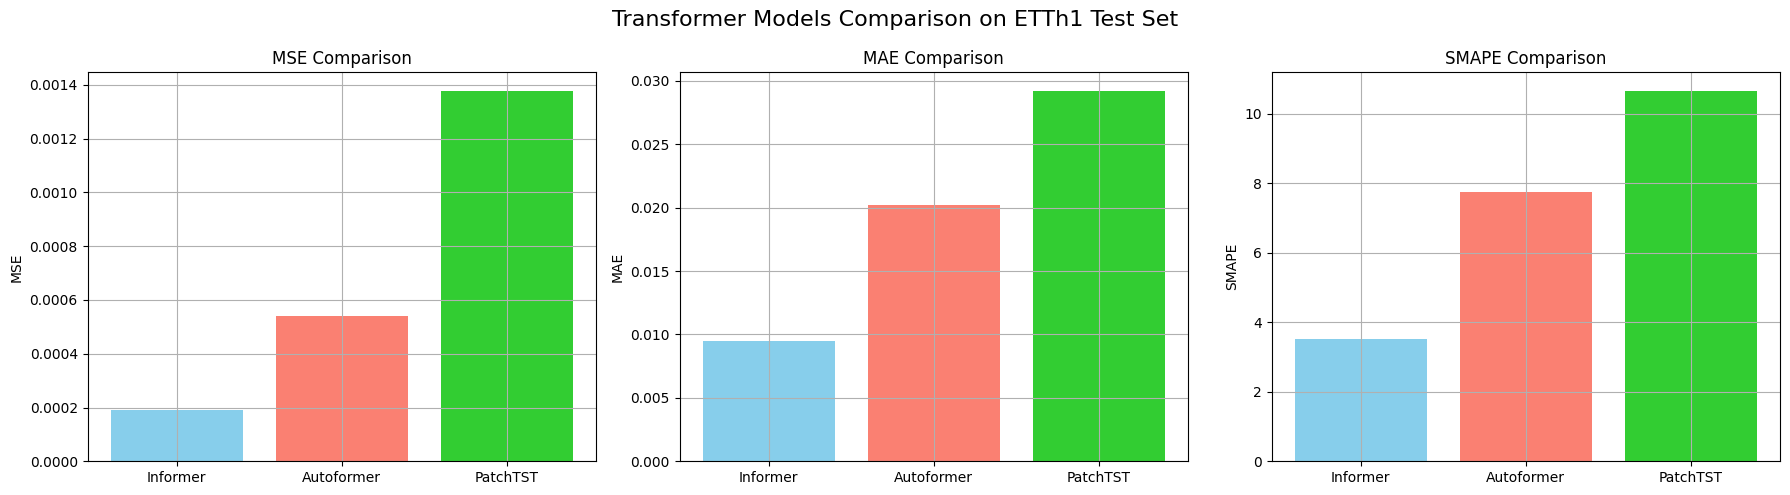

In [12]:
# 📊 Plot all metrics
metrics = ['MSE', 'MAE', 'SMAPE']
colors = ['skyblue', 'salmon', 'limegreen']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(metrics):
    axs[i].bar(results_df['Model'], results_df[metric], color=colors)
    axs[i].set_title(f'{metric} Comparison')
    axs[i].set_ylabel(metric)
    axs[i].grid(True)

plt.suptitle('Transformer Models Comparison on ETTh1 Test Set', fontsize=16)
plt.tight_layout()
plt.savefig('../../outputs/metrics/transformer_comparison_results.png')
plt.show()

In [13]:
# 💾 Save results
results_df.to_csv('../../outputs/metrics/transformer_comparison_results.csv', index=False)
print("✅ Comparison results saved to CSV and plot exported!")

✅ Comparison results saved to CSV and plot exported!
